# Notebook to introduce respy 
Introduces basic functions of library for processing respiration recordings (single best chest stretch).

https://pypi.org/project/respy/0.1.1/

    pip install respy

This library provides some basic signal processing tools to extract respiration phase and related features from recordings of respiration from healthy awake adults. Initial developed to track respiration phase in music listeners (2019), the features are now being adapted to also detect respiration phase in performing musicians (2023) and similar active conditions. 

Chest stretch measurements do not perfectly capture airflow. Many interesting aspects of respiratory behaviour require more demanding sensor arrangements to accurately capture gas partial pressures and volumns of air displaced. While measured change in chest circumference is often analogous to air flow, changes in posture and respiration strategy can shift the scale. 

This library instead focuses on respiratory phase timing, which is more reliably captured with this sensor. (Though there is also some noise here as well.) This time domain analysis of a quasi-oscillatory signal uses optimised heuristics to distinguish respiratory events from sensor noise. With accurate detection of indiviual breaths, many interesting follow questions can be asked, such as the relationship of respiratory phase to concurrently presented stimuli or bodily actions. 

And after respiratory phase information has been extracted with some degree of reliability, respiratory shape and style can be assessed with much greater refinement. 

This notebook uses a set of demo respiraton recordings to demonstrate the phase extraction and classification of respiratory behaviour.

Note: if there is a problem installing respy from pip, the same functions are available in a definitions .py file within this directory. Create and run a cell with the lines:

    %load_ext autoreload
    %autoreload 1
    %aimport rp
    %aimport aa
    
And replace module calls to respy. with rp. and act. with aa.

The definitions of respy and act are thus readable in these files as well, including full function definitions with input and output options listed in full.

# Loading and evaluating respiration features


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

from respy import respy
from respy import act

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Demonstrate respiratory signal extraction with sample recordings of a single participant listening to short music clips while standing. (Upham, Zelechowska, Gonzalez, and Jensenius 2021).

These respiration traces were measured with Sweetspot single belt sensors, sampling at 10 Hz. 

Analysis toolbox expects pandas dataframes of stretch sensor values with numerical index in seconds.

In [2]:
data_loc = './demo_data/'
sf = 10
df = pd.read_csv(data_loc + 'Listener_HpSp.csv',index_col = 0)
df

,Speakers,Headphones
Time_s,,
0.0,1853.0,1813.0
0.1,1850.0,1808.0
0.2,1843.0,1802.0
0.3,1840.0,1798.0
0.4,1843.0,1797.0
...,...,...
499.6,1823.0,1739.0
499.7,1822.0,1744.0
499.8,1819.0,1755.0


Chest expansion measurements are always relative, unitless. 
respnormed filters measurement time series and uses signal properties to scale depth. 
Sample rate estimated form dataframe index. Default filtering is 1 Hz lowpass. 

In [4]:
sample_dur = 120
sig = df.loc[0:sample_dur,'Speakers'].copy()


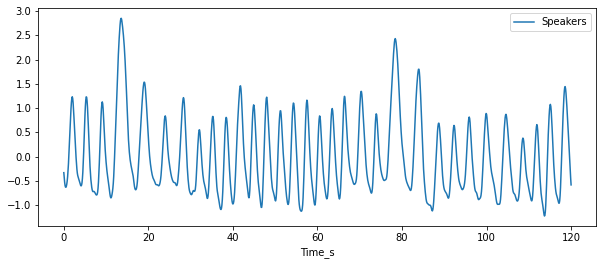

In [5]:
sample_dur = 120 # index is in seconds
sig = df.loc[0:sample_dur,'Speakers']
sig_filt  = respy.respnormed(sig,filtering_range = [1])
sig_filt.plot(figsize=(10,4))
plt.show()

Inspiration_Extraction function uses heuristic algorithm to pick out timing of inspiration and expiration onsets. Algorithm design and performance in Ch 4 of Detecting the adaptation of listeners' respiration to heard music (Upham, 2018). 

Output is detected onsets of inspirations and expirations per breath in signal index sample time.

In [6]:
Breaths = respy.Inspiration_Extract(sig_filt['Speakers'])
Breaths

,In,Ex
0,0.8,1.9
1,4.3,5.3
2,8.0,9.0
3,11.5,13.4
4,17.3,18.9
5,22.9,23.9
6,27.0,28.2
7,31.2,32.0
8,34.2,35.2
9,37.4,38.4


Breath_Features function extracts statistics of two phase respiration cycle decriptions: 

      'In' - Sample time point closest to inspiration onset
      'Ex' - Sample time point closest to subsequent expiration onset
      'Depth' - signal value difference from 'In' and 'Ex'
      'Insp_T'- Duration from 'In' to 'Ex'
      'Period_T' - Duration to next 'In' (if it is in the signal)
      'Exp_T' - Duration from 'Ex' to next 'In' (if it is in the signal)
      'IE_Ratio' - Insp_T/Exp_T, usually a value between [0.2,1]
      'Insp_V' - Average velocity of inspiration (Depth/Insp_T)(usually a bit under mode)
      'Exp_V' - Average velocity of expiration (Depth/Exp_T) (usually over mode)


In [7]:
respy.Breath_Features(sig_filt['Speakers'])

,In,Ex,Depth,Insp_T,Period_T,Exp_T,IE_Ratio,Insp_V,Exp_V
0,0.8,1.9,1.708275,1.1,3.5,2.4,0.458333,1.552977,0.711781
1,4.3,5.3,1.746267,1.0,3.7,2.7,0.370370,1.746267,0.646766
2,8.0,9.0,1.793919,1.0,3.5,2.5,0.400000,1.793919,0.717568
3,11.5,13.4,3.574652,1.9,5.8,3.9,0.487179,1.881396,0.916577
4,17.3,18.9,2.113094,1.6,5.6,4.0,0.400000,1.320684,0.528273
5,22.9,23.9,1.273257,1.0,4.1,3.1,0.322581,1.273257,0.410728
6,27.0,28.2,1.650883,1.2,4.2,3.0,0.400000,1.375736,0.550294
7,31.2,32.0,1.081242,0.8,3.0,2.2,0.363636,1.351553,0.491474
8,34.2,35.2,1.528904,1.0,3.2,2.2,0.454545,1.528904,0.694956
9,37.4,38.4,1.776870,1.0,2.9,1.9,0.526316,1.776870,0.935195


Breath_Continues_Features evaluates the same and interpolates (stepwise, forward) to respiration signal sample times.

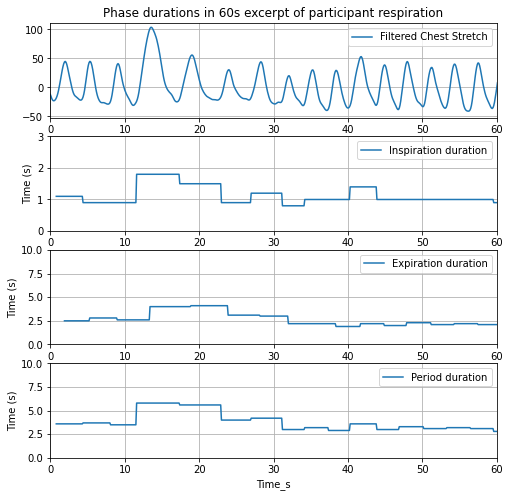

In [8]:
Breaths = respy.Breath_Continues_Features(sig,scaling=1,filtered=False,interp_style='previous')

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(411)
Breaths['Filt'].plot(ax=ax)
plt.xlim(0,60)
plt.grid()
plt.legend(['Filtered Chest Stretch'])
plt.title('Phase durations in 60s excerpt of participant respiration')
ax = plt.subplot(412)
Breaths['Insp_T'].plot(ax=ax)
plt.xlim(0,60)
plt.ylim(0,3)
plt.ylabel('Time (s)')
plt.grid()
plt.legend(['Inspiration duration'])
ax = plt.subplot(413)
Breaths['Exp_T'].plot(ax=ax)
plt.xlim(0,60)
plt.ylim(0,10)
plt.ylabel('Time (s)')
plt.grid()
plt.legend(['Expiration duration'])
ax = plt.subplot(414)
Breaths['Period_T'].plot(ax=ax)
plt.xlim(0,60)
plt.ylim(0,10)
plt.ylabel('Time (s)')
plt.grid()
plt.legend(['Period duration'])
plt.savefig('./plots/sampl_contFeats.png',dpi = 400)

plt.show()

# Respiration phases

Human respiration is often stuided in two phases, Inspiration and Expiration, however there are situations where it is helpful to describe the cycle in three intervals or four. 

respy looks to identify three intervals per cycle: Inspiration phase, expiration phase, and post-expiration pause. 

For vocalisation, diving, and other distinct conditions, additional pauses can be injected within the Inspiration-Expiration interval. 

### Inspiration
The inspiration phase of human respiration is always active: respiratory muscles coordinate to expand lung volumn, creating negative pressure to draw fresh air into the body. One of the most important muscles for this process is the diapham, a wide stretch of muscle between the chest and abdominal cavity that curves up when relaxed and lowers/flattens with contraction to expand the volumn of lung tissue. Other key muscles span the rib cage (obliques), positioned to lift the bones and expand this structure when contracted. (It is this expansion that is measured by single-belt chest stretch sensors.) Inspirations can also be deepened and extended with cooperation from the abdominals, trapezius, etc. A wonder and challenge for capturing the details of inspiration is the flexibility of this phase. There are many ways to produce the same displacement of air in the same ammount of time, and the specific inspiration action performed depends on posture, practice, and sensory conditions on top of the functional priority of gas exchange. When deliberately extended, an inspiration phase can last several seconds, but usually breath is actively being drawn for only 400 to 1100 ms. Closer to a second for quiet breathing, less than half that when inspiring for speech or other actions. 

### Expiration
The expiration phase of the human respiratory cycles can active or entirely elastic. Under relaxed conditions, expiration is usually passive and mechanical. Instead of a network of muscles working to compress the lungs, the respiratory system is simply allowed to revert to a stable state through the natural relaxation of the inspiration muscles and elastic contraction of lung tissue. During quiet breathing, sleep, and similar states, elastic expiration directly follows the peak of inspiration, releasing the potential energy injected into the system by the preceeding actively drawn of breath. 

Active expiration can take many forms. The expiration muscles serve to contract the rib cage (intercostals) and push up on the diaphram (abdominals), forcing air out of the lungs more quickly and past the point of relaxed stability if greater volumns of air need to be displaced per cycle. Physical exersion often requires faster gas exchange than can be achieved with elastic expiration, and the result is a cycle that can carry momentum between phases in both directions, potential energy also aiding the transition from expiration to inspiration. This mechanical component of this respiratory pattern results in a shape of chest stretch measurements closer to the familiar sinusoide as the system is tuned to meet a steady high drive for CO2 expulsion.

Vocalisation and other expressive expirations are also active, though their shape can be quite different from expiration for exertion. Exquisitely controlled lung pressure for sound production is achieved through the cooperative engagement of both inspiration and expiration muscles. With some practice, humans can extend the expiration phase from a smooth 1.5-2 second exhale to a steady outflow of air over tens of seconds. And expirations for vocalisation are not always smooth, they are often paused for articulation and interrupted for mini inspirations. 

In chest stretch measurements, the shape of this kind of active exhale depends in part on whether the sound generation involves some form of blockage or resistence. For a high pressure instrument or sharp yell, the chest cavity can be compressed to increase the pressure before any air is released. Additionally, these breaths often involve displacing extraordinary volumns of air per cycle and a single chest stretch sensor can not be counted on to capture all that is happening to support these extended expertly controlled exhalations. As such, the respy library only gives a best guess at the onset, end, and character of expressive expirations from the signal information available. 

### Post-expiration pause
When demand for air flow is normal and low, the default state of the lungs is mostly deflated. Active inspiration flows to elastic expiration and then the system waits to be prompted to inflate again. This interval of waiting is the post expiraton pause, and it is the most variable phase of respiration in stable conditions. It is also what breaks oscillatory models of respiration outside of high exersion. The respiratory system has no memory: after air is expelled in expiration, there is no mechanical drive to keep breathing the same way as before. Instead, the respiratory system seems oriented towards coordinating between current demand and upcoming actions. Flexibility in inspiration depth makes it easy to adjust to small delays or advances in inspiration time without risking homeostasis. As such, the post expiration pause can be less than 400 ms one cycle and over 2000 ms the next without ever disturbing the breather. # check these numbers empirically

During active exertion, of course, there is no post-expiration pause at all. And during expressive expirations like speech, there can be pauses that are not post-expiration. However, the sensory and physiological conditions of the post-expiration pause make it well worth tracking when considering respiratory phase timing in really everyday respiratory sequences. 

### Other Pauses

As the respy library is extended to capture phase information in respiration sequences during more varied forms of action, it is useful to identify more effortful pauses in the respiratory cycle. These can occure in the preparation of sound generating expulsions or as some measurable duration of stable chest circumpherence between intervals of slow contraction. This isn't part of respy yet, but it needs to be. That's why we are tryinging the algorithm a new with more varied measurements. 

Resp_phases evaluate standard breath cycle components according to this three phase representation. 

Resp_phases inputs include thresholding criteria for "high flow" intervals of inspiration and expirations, and the "low flow" interval of the post expiration pause. Defaults designed for signals after respnorm normalisation. 

In [9]:
flow_high=0.5
flow_low = 0.3
respPhases = respy.Resp_phases(sig_filt['Speakers'],flow_high, flow_low) 
respPhases

,Signal,Inspiration_Onset,Expiration_Onset,Inspiration,Inspiration_diff,Expiration,Expiration_diff,Inspiration_high,Expiration_high,Inspiration_V,Expiration_V,Post_Expiration
Time_s,,,,,,,,,,,,
0.0,-0.330529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,-0.438715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,-0.531715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,-0.596768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,-0.629035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
119.6,0.044516,NaN,NaN,NaN,NaN,0.044516,-0.178305,NaN,0.044516,NaN,NaN,NaN
119.7,-0.131245,NaN,NaN,NaN,NaN,-0.131245,-0.175761,NaN,-0.131245,NaN,NaN,NaN
119.8,-0.295574,NaN,NaN,NaN,NaN,-0.295574,-0.164329,NaN,-0.295574,NaN,NaN,NaN


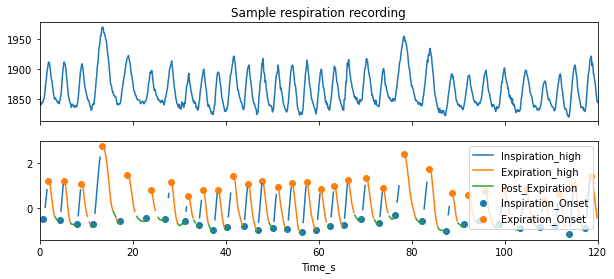

In [10]:
fig, axs = plt.subplots(2,1, sharex='all',figsize=(10,4))
ax = axs[0]
sig.plot(ax=ax)
plt.xlim([0,sample_dur]) 
ax.set_title('Sample respiration recording')

ax = axs[1]

CP = respPhases.loc[respPhases['Inspiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Inspiration_Onset')
respPhases['Inspiration_high'].plot(ax=ax)
CP = respPhases.loc[respPhases['Expiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Expiration_Onset')
respPhases['Expiration_high'].plot(ax=ax)
respPhases['Post_Expiration'].plot(ax=ax)

plt.legend()
plt.savefig('./plots/phase_components.png')
plt.show()

Flow thresholds serve to estimate intervals of phases with sensory properties, like when flow is most audible.

These phase components have beem most interesting for looking at phase alignment to heard music, evaluated statistically over repeated listenings.

# Treating sets of concurrent respiration recordings

Demonstration of concurrent respiration recordings from repeated response experiment with case study participant, Joan (Upham, 2018), as she listenned to an a capella performances of a french canadian folk song.

These respiration traces were measured with Thought Technology respiration belt and sampled at 20 Hz. 

Analysis toolbox expects pandas dataframes of stretch sensor values with numerical index in seconds.

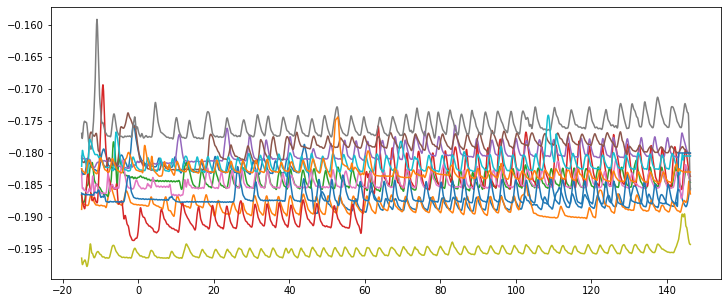

,0,1,2,3,4,5,6,7,8,9,10,11
-15.00,-0.182506,-0.188810,-0.186551,-0.186612,-0.180527,-0.180851,-0.183333,-0.176958,-0.196416,-0.182081,-0.186268,-0.182488
-14.95,-0.182819,-0.188241,-0.186960,-0.186773,-0.180690,-0.181035,-0.184142,-0.177364,-0.196789,-0.181164,-0.186357,-0.182584
-14.90,-0.183087,-0.187775,-0.187314,-0.186964,-0.180828,-0.181193,-0.184821,-0.177648,-0.197100,-0.180400,-0.186427,-0.182670
-14.85,-0.183278,-0.187471,-0.187571,-0.187177,-0.180923,-0.181311,-0.185290,-0.177754,-0.197311,-0.179883,-0.186469,-0.182736
-14.80,-0.183380,-0.187342,-0.187718,-0.187401,-0.180972,-0.181386,-0.185536,-0.177675,-0.197411,-0.179634,-0.186483,-0.182781
...,...,...,...,...,...,...,...,...,...,...,...,...
-10.20,-0.182175,-0.188251,-0.185411,-0.179465,-0.181372,-0.180111,-0.186025,-0.171597,-0.195775,-0.180543,-0.186340,-0.181116
-10.15,-0.182002,-0.188236,-0.185451,-0.178706,-0.181359,-0.180249,-0.186059,-0.172075,-0.195800,-0.180530,-0.186474,-0.180977
-10.10,-0.181816,-0.188220,-0.185497,-0.177984,-0.181345,-0.180397,-0.186090,-0.172456,-0.195815,-0.180560,-0.186604,-0.180864
-10.05,-0.181617,-0.188204,-0.185548,-0.177306,-0.181330,-0.180547,-0.186118,-0.172789,-0.195825,-0.180627,-0.186724,-0.180787


In [11]:
RespRecs = pd.read_csv(data_loc + 'P2_listenings_Rosier.csv',index_col = 0)
RespRecs.plot(figsize=(12,5),legend=False)
plt.show()
RespRecs.loc[:-10,:]

Chest stretch normalisation with median difference.

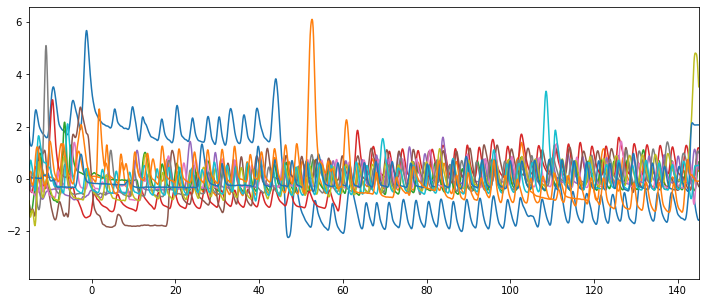

In [12]:
RespNorm = RespRecs.copy()
listenings = RespRecs.columns
for part in listenings:
    # gather statistics on breath shapes in original stretch unites across both sessions
    sig = RespRecs.loc[:,part]
    br = respy.Breath_Features(sig,scalingfactor=1)
    # normalised each sessions resp recording according to statistics across the two
    newSig=respy.respnormed(sig,scaling=1/br['Depth'].median())
    RespNorm.loc[:,part]=newSig.iloc[:,0]
RespNorm.plot(figsize=(12,5),legend=False)
plt.xlim([-15,145]) 
plt.show()

Heatmaps make a useful alternative visual representation of stimulus aligned respiration signals using ploting functions from seaborn library (sns). After normalisation, respiration signals are differenced and plot uses low thresholds to clearly distinguish chest expansion and contraction from middling midrange. 

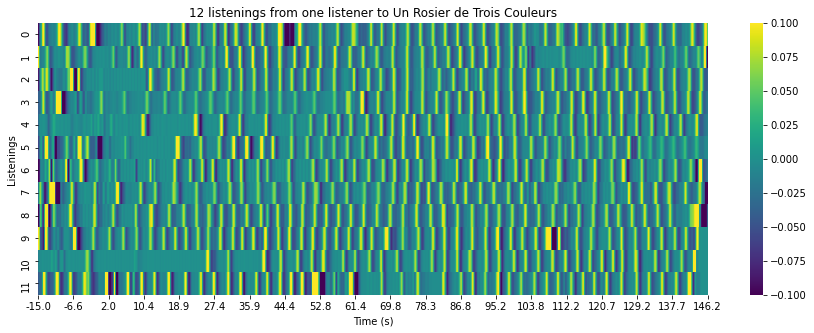

In [13]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = RespNorm.diff().copy()
chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="viridis")

#compensate for heatmap terrible xtick labels
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)

ax.set_ylabel('Listenings')
ax.set_title('12 listenings from one listener to Un Rosier de Trois Couleurs')
ax.set_xlabel('Time (s)')
plt.savefig('./plots/Full_Scaled_Resp_aligned.png',dpi = 300)
plt.show()


 See notebook Respy_Phase_Alignment.ipynb for demonstration of assessing phase alignment with activity analysis

# Respiration in musicians as they perform

Data excerpt from a violinist in an orchestra over repeated performances of the same piece. Stavangar Bodies in Concert experiment 2023. 

Respiration belt signals sampled up to 50 Hz and normalised to median inspiration depth during intervals between pieces. These measurements from differnt performances have been timewarped to match the times of the first concert. The change with warping was very small for this short excerpt of 40 s

In [14]:
df_resp = pd.read_csv(data_loc + 'Violinist_respiration_repeated_performances.csv',index_col = 0)


In [16]:
flow_high=0.5
flow_low = 0.3
respPhases = respy.Resp_phases(df_resp['VN102_C2'],flow_high, flow_low) 
respPhases

,Signal,Inspiration_Onset,Expiration_Onset,Inspiration,Inspiration_diff,Expiration,Expiration_diff,Inspiration_high,Expiration_high,Inspiration_V,Expiration_V,Post_Expiration
-5.000,2.730172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.980,2.732004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.960,2.734652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.940,2.737352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.920,2.740513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
39.808,2.850966,NaN,NaN,NaN,NaN,2.850966,0.002078,NaN,NaN,NaN,NaN,NaN
39.828,2.855641,NaN,NaN,NaN,NaN,2.855641,0.004675,NaN,NaN,NaN,NaN,NaN
39.848,2.861501,NaN,NaN,NaN,NaN,2.861501,0.005860,NaN,NaN,NaN,NaN,NaN
39.868,2.875294,NaN,NaN,NaN,NaN,2.875294,0.013793,NaN,NaN,NaN,NaN,NaN


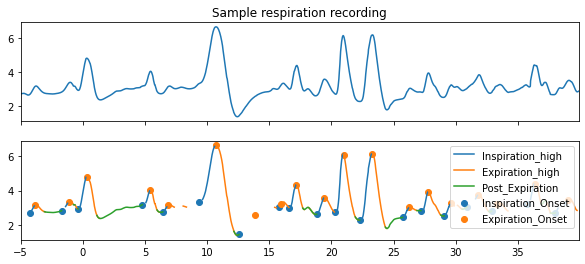

In [17]:
fig, axs = plt.subplots(2,1, sharex='all',figsize=(10,4))
ax = axs[0]
df_resp['VN102_C2'].plot(ax=ax)
plt.xlim([ df_resp.index[0], df_resp.index[-1]]) 
ax.set_title('Sample respiration recording')

ax = axs[1]

CP = respPhases.loc[respPhases['Inspiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Inspiration_Onset')
respPhases['Inspiration_high'].plot(ax=ax)
CP = respPhases.loc[respPhases['Expiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Expiration_Onset')
respPhases['Expiration_high'].plot(ax=ax)
respPhases['Post_Expiration'].plot(ax=ax)

plt.legend()
plt.savefig('./plots/phase_components_musician.png')
plt.show()

The Inspiration detection heuristic can be a bit messy about picking out breaths during active music making. It may be the algorithm is picking up more cycles than actually performed. However, the timing of phases on breaths accurately detected is not bad. 

But for now, it is still safer to looking at extremes of chest stretch rather until phase component algorythms can be value checked against the more varied respiratory activity of music performance conditions.

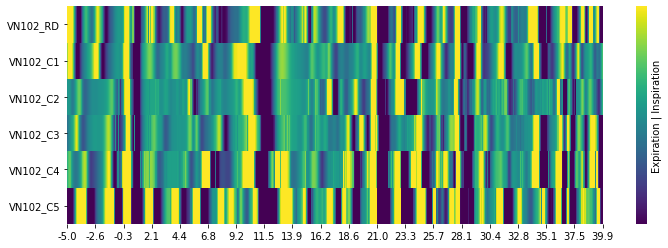

In [18]:

fig, (ax) = plt.subplots(1, 1,figsize = [12,4],sharex = True)
chart = sns.heatmap(data=df_resp.diff().transpose(),vmin=-0.05, vmax=0.05, ax=ax,cmap='viridis',cbar_kws={'label': 'Expiration | Inspiration','ticks':[]})#
times = df_resp.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)

plt.savefig('./plots/Resp_performance_aligned_timewarped.png',dpi = 300)

plt.show()